<a href="https://colab.research.google.com/github/mrpiay/mrbeam/blob/main/mrbeam_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP #1: install mrbeam framework**

In [ ]:
! git clone https://github.com/mrpiay/mrbeam.git

In [ ]:
! wget https://github.com/liamedeiros/ehtplot/archive/refs/heads/master.zip
! unzip master.zip -d .
! wget https://github.com/achael/eht-imaging/archive/refs/tags/v1.2.7.zip
! unzip v1.2.7.zip -d .
! pip install pygmo
! pip install ./ehtplot-master
! pip install ./eht-imaging-1.2.7
! pip install ./mrbeam/mr_beam/itreg
! pip install ./mrbeam/mr_beam/libwise-0.4.7-light
! pip install ./mrbeam/mr_beam/MSI
! pip install ./mrbeam/mr_beam/imagingbase
! pip install ./mrbeam/mr_beam/ga

In [ ]:
! pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
! conda install -c conda-forge pynfft

### **(!) Restart session in Colab: Runtime -> Restart session (Ctrl+M)**









# **STEP #2: create a user defined multi-objective problem (MOP)**

In [ ]:
import numpy as np
import GA.solver as solver
from GA.problems import EHT
import sys
import ehtim as eh
import matplotlib.pyplot as plt

#mrpiay
import json
from pprint import pprint
#mrpiay

**Create / read json config file**

In [2]:
# Way of reading the config_file... if json is done, don't needed

# IMPORTANT!: Remember to change the path of img and uvf in your config

#mrpiay config = solver.read_config_params(config_file, 'EHT')

#mrpiay
def create_config_json():
  print(json.dumps(config, indent = 4))
#create_config_json()
#mrpiay

#mrpiay config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config'
outfile = './mrbeam/mr_beam/mrpiay/logger.log'

#mrpiay
config_file = './mrbeam/mr_beam/mrpiay/ring_16_first_test.config.json'
#mrpiay

In [3]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters. WE WON'T USE THEM FOR NOW
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 3                 # Total compact flux density (Jy)
npix      = 16                # Number of pixels across the reconstructed image
fov       = 160*eh.RADPERUAS    # Field of view of the reconstructed image

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
sys_noise  = 0.02               # fractional systematic noise
                                # added to complex visibilities

#data weights
data_term = {'amp'    : 1.0,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

stop      = 1e-4                # Imager stopping criterion
gain_tol  = [0.02,0.2,0.2]          # Asymmetric gain tolerance for self-cal; we expect larger values
                                # for unaccounted sensitivity loss
                                # than for unaccounted sensitivity improvement
uv_zblcut = 0.1e9               # uv-distance that separates the inter-site "zero"-baselines
                                # from intra-site baselines
zero_baseline = ['ALMA', 'APEX']    # baseline to measure zero-spacing flux
#rescaling = 0.04              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1.6*10**11]       #cbar-lims for interactive plotting (brightness temperature)

**Create obs, prior & true_img**

In [ ]:
# Prior definition for the entropy regularizer

#mrpiay obs = eh.obsdata.load_uvfits(config['uvf'])

#mrpiay
with open(config_file) as f:
    config = json.load(f)
#mrpiay

obs = eh.obsdata.load_uvfits(config['uvf'])
true_img = eh.image.load_fits(config['img'])
obs_sc = obs.copy()

#mrpiay
npix = true_img.xdim
fov = true_img.fovx()
zbl = config['zbl']
rescaling = config['rescaling']
#mrpiay

prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))
prior = prior.add_gauss(1e-2*zbl, (100*eh.RADPERUAS, 100*eh.RADPERUAS, 0, 100*eh.RADPERUAS, 100*eh.RADPERUAS))

#mrpiay
# Rescale the prior flux so it matches the measured zbl flux
prior.imvec *= zbl / prior.total_flux()
#mrpiay

**Show obs, prior & true_img**


config:

{
    "reg_term": {
        "l1w": 1.0,
        "simple": 0.1,
        "tv": 10.0,
        "tv2": 10.0,
        "lA": 10.0,
        "flux": 10000.0
    },
    "data_term": {
        "vis": 1.0,
        "amp": 0.0,
        "cphase": 0.0,
        "logcamp": 0.0
    },
    "img": "/content/mrbeam/mr_beam/mrpiay/ring_16.fits",
    "uvf": "/content/mrbeam/mr_beam/mrpiay/ring_16.uvfits",
    "rescaling": 0.02,
    "zbl": 0.6,
    "grid_size": 7,
    "seed_initial": 12,
    "prior_fwhm": 100.0,
    "num_cores": 64,
    "generations": 10,
    "neighbours": 6,
    "decomposition_method": "grid",
    "decomposition_seed": 12,
    "CR": 1.0,
    "F": 0.5,
    "eta_m": 20.0,
    "realb": 0.9,
    "limit": 2,
    "preserve_diversity": true,
    "pop_size": 1716,
    "mode": "pareto"
}

obs:

{'_tarr': array([('AA',  2225060.8136 , -5440059.59994, -2481681.15054, 0., 0., 0.+0.j, 0.+0.j, 0., 0., 0.),
       ('LM',  -768715.632  , -5988507.072  ,  2063354.852  , 0., 0., 0.+0.j, 0.+0.j, 0., 0

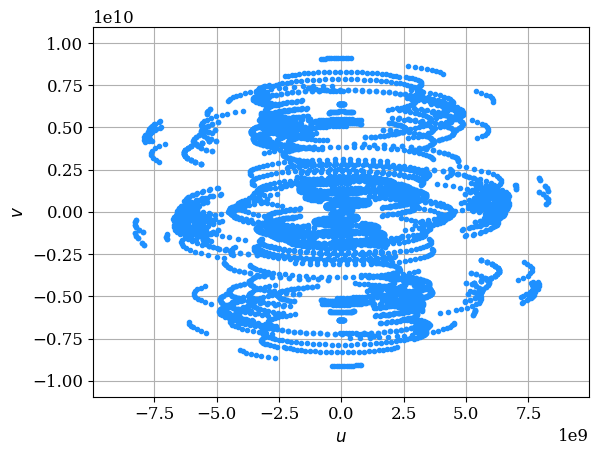

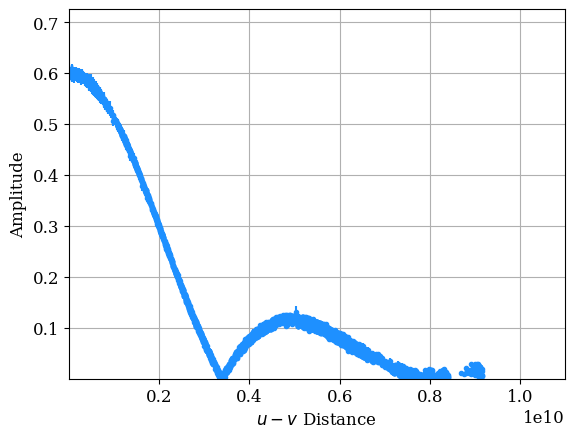

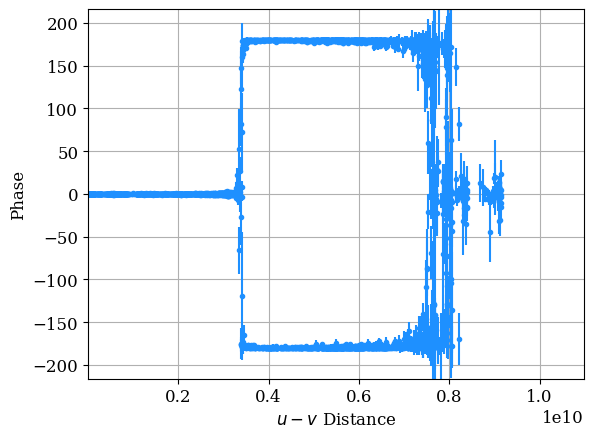


obs.cleanbeam



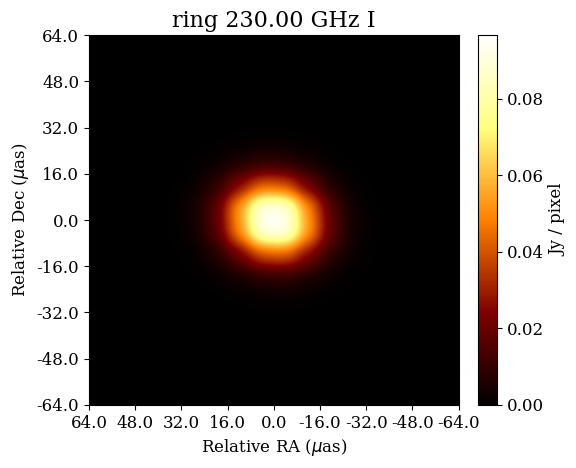


obs.dirtybeam



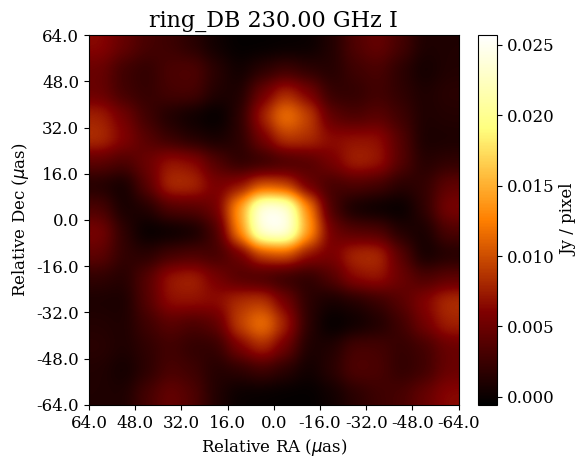


obs.dirtyimage



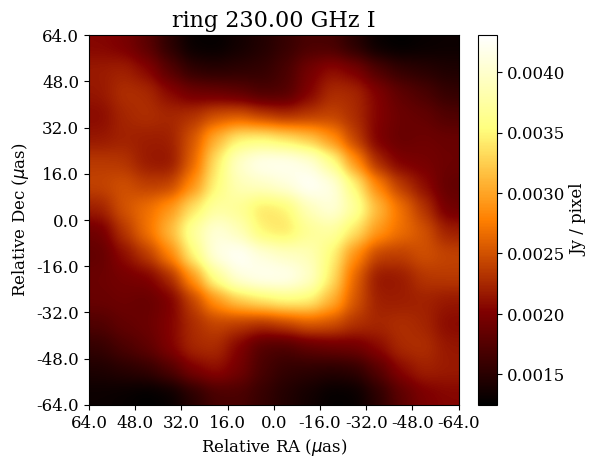


prior:

{'_imdict': {'I': array([3.52929098e-04, 2.90659241e-04, 2.31912067e-04, 1.80956842e-04,
       1.41157625e-04, 1.13727623e-04, 9.61592851e-05, 8.25611246e-05,
       6.72586271e-05, 4.88980273e-05, 3.06321436e-05, 1.63843290e-05,
       7.59571124e-06, 3.18192157e-06, 1.28636411e-06, 5.34697071e-07,
       2.90659241e-04, 2.40593776e-04, 1.96369875e-04, 1.65787328e-04,
       1.57211011e-04, 1.73481794e-04, 2.03650689e-04, 2.23391499e-04,
       2.10802469e-04, 1.64769886e-04, 1.05120960e-04, 5.45627485e-05,
       2.31669166e-05, 8.19858605e-06, 2.53303865e-06, 7.52073297e-07,
       2.31912067e-04, 1.96369875e-04, 1.76123769e-04, 1.92891123e-04,
       2.73580423e-04, 4.27119681e-04, 6.12640761e-04, 7.40297852e-04,
       7.30302237e-04, 5.81769636e-04, 3.72841589e-04, 1.92078320e-04,
       7.96513733e-05, 2.67168957e-05, 7.35107909e-06, 1.72751738e-06,
       1.80956842e-04, 1.65787328e-04, 1.92891123e-04, 3.23412345e-04,
       6.36067678e-04, 1.15682564e-03, 1.76213726e

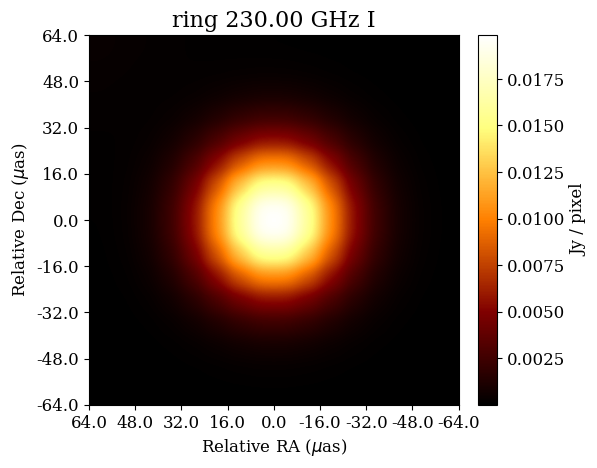


true_img:

{'_imdict': {'I': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.71237867e-15,
       1.11518846e-12, 1.21742731e-10, 1.46710065e-09, 5.54145513e-09,
       5.54145513e-09, 1.46710065e-09, 1.21742731e-10, 1.11518846e-12,
       2.71237867e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.71237867e-15, 1.11518846e-12, 1.22857920e-10,
       1.92560790e-09, 5.55957112e-08, 6.08737740e-07, 2.27994580e-06,
       2.27994580e-06, 6.08737740e-07, 5.55957112e-08, 1.92560790e-09,
       1.22857920e-10, 1.11518846e-12, 2.71237867e-15, 0.00000000e+00,
       0.00000000e+00, 1.11518846e-12, 4.58507257e-10, 5.01759961e-08,
       6.53249423e-07, 7.74267350e-06, 6.81283377e-05, 2.49376590e-04,
       2.49376590e-04, 6.81283377e-05, 7.74267350e-06, 6.53249423e-07,
       5.01759961e-08, 4.58507257e-10, 1.11518846e-12, 0.00000000e+00,
       2.71237867e-15, 1.22857920e-10, 5.01759961e-08, 5.46724962e-06,
       6.64582589e-05, 3.14578526e-04, 1.042316

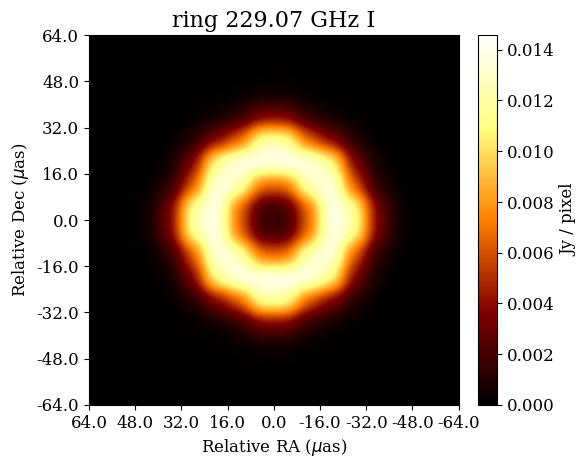


Use MEM with complex visibilities:

Generating I image...
Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 1765.906870 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 88245.343498
Total Data 1:  3592
Total Pixel #:  256
Clipped Pixel #:  256

time: 0.876595 s
J: -24.682789
Final Chi^2_1: 0.501869 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


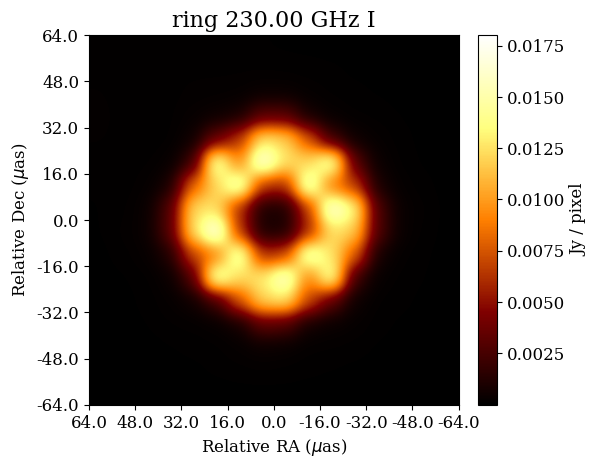


Blur and restart:

Generating I image...
Initial S_1: -0.000000 S_2: 0.000000 S_3: 0.000000
Initial Chi^2_1: 171.751058 Chi^2_2: 1.000000 Chi^2_3: 1.000000
Initial Objective Function: 1707.540183
Total Data 1:  3592
Total Pixel #:  256
Clipped Pixel #:  256

time: 2.478729 s
J: -6.211175
Final Chi^2_1: 0.367888 Chi^2_2: 1.000000  Chi^2_3: 1.000000
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT


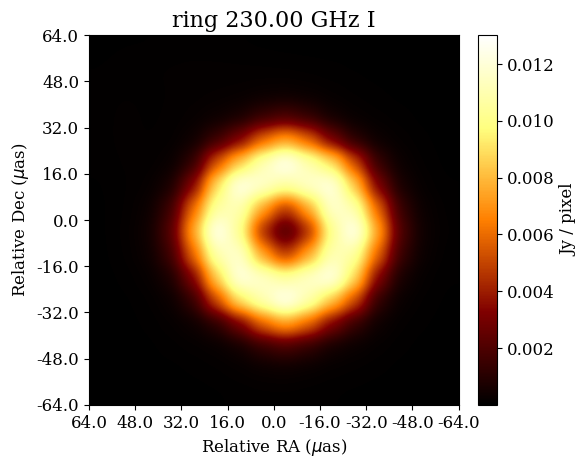

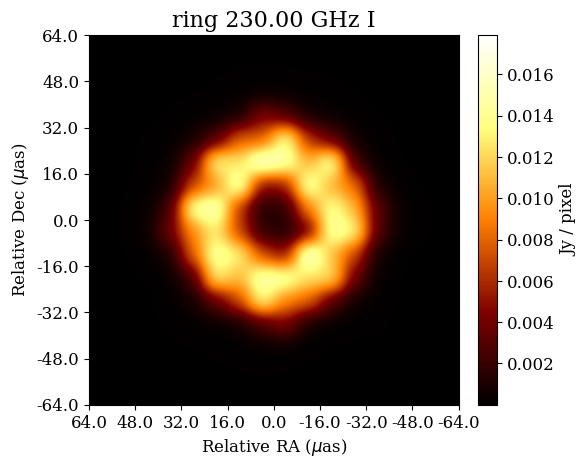


Fitness:

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


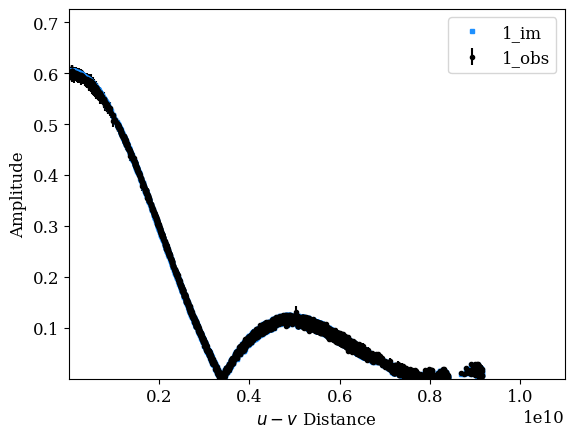

Producing clean visibilities from image with nfft FT . . . 
Adding gain + phase errors to data and applying a priori calibration . . . 
Warning!: in add_noise, some SEFDs are <= 0!
NOT recomputing sigmas, which may result in double systematic noise


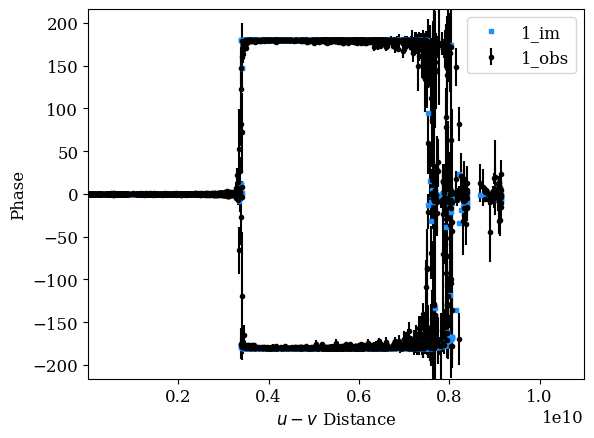

<Axes: xlabel='$u-v$ Distance', ylabel='Phase'>

In [5]:
#mrpiay
print('\nconfig:\n')
print(json.dumps(config, indent=4))

print('\nobs:\n')
pprint(vars(obs))
obs.plotall('u', 'v', conj=True)
obs.plotall('uvdist', 'amp')
obs.plotall('uvdist', 'phase')

print('\nobs.cleanbeam\n')
cbeam = obs.cleanbeam(npix,fov)
cbeam.display()

print('\nobs.dirtybeam\n')
dbeam = obs.dirtybeam(npix, fov)
dbeam.display()

print('\nobs.dirtyimage\n')
dim = obs.dirtyimage(npix, fov)
dim.display()

print('\nprior:\n')
pprint(vars(prior))
prior.display()

print('\ntrue_img:\n')
pprint(vars(true_img))
true_img.display()

print('\nUse MEM with complex visibilities:\n')
out = eh.imager_func(obs, prior, prior, zbl, d1="vis", alpha_d1=50, s1="gs",maxit=100, show_updates=False)
out.display()

print('\nBlur and restart:\n')
beamparams = obs.fit_beam()
outblur = out.blur_gauss(beamparams, 0.5)
out = outblur
out = eh.imager_func(obs, out, out, zbl, d1="vis", alpha_d1=10 ,s1="gs", maxit=150, show_updates=False)
outblur.display()
out.display()

print('\nFitness:\n')
eh.plotting.comp_plots.plotall_obs_im_compare(obs, out, "uvdist", "amp")
eh.plotting.comp_plots.plotall_obs_im_compare(obs, out, "uvdist", "phase")
#mrpiay

**Create EHT & EHT.fit**

mr_beam/ga/GA/problems/EHT.py

```
self.data_fidelity_term =   data_term['vis'] * self.func_vis \
                          + data_term['amp'] * self.func_amp \
                          + data_term['cphase'] * self.func_cph \
                          + data_term['logcamp'] * self.func_logcamp

self.ob1 = self.data_fidelity_term + self.penalty_term
self.ob2 = self.data_fidelity_term + self.penalty_term2
self.ob3 = self.data_fidelity_term + self.penalty_term3
self.ob4 = self.data_fidelity_term + self.penalty_term4
self.ob5 = self.data_fidelity_term + self.penalty_term5
self.ob6 = self.data_fidelity_term + self.penalty_term6
self.ob7 = self.data_fidelity_term

```

```
def fitness(self, x):
  if 'fit' not in self.__dict__:
      self.fit = self.setFit()
      return [self.fit.ob1(x),self.fit.ob2(x),self.fit.ob3(x),self.fit.ob4(x),self.fit.ob5(x), self.fit.ob6(x), self.fit.ob7(x)]

```

In [ ]:
# Getting the inputs

reg_term = config['reg_term']
data_term = config['data_term']
rescaling = config['rescaling']
zbl = config['zbl']

# Now, we create the MOP

EHTfit = EHT.EHT(obs, prior, data_term, reg_term, rescaling, zbl, npix**2)
EHTfit.setFit()

**Show EHT & EHT.fit**

In [7]:
#mrpiay
print('\nEHT:\n')
pprint(vars(EHTfit))
print('\nEHT.fit:\n')
pprint(vars(EHTfit.fit))
#for i in list(vars(EHTfit.fit).keys()):
#  if 'fid' in i:
#    pprint(vars(getattr(EHTfit.fit, i)))
#mrpiay


EHT:

{'data_term': {'amp': 0.0, 'cphase': 0.0, 'logcamp': 0.0, 'vis': 1.0},
 'dim': 256,
 'fit': <GA.problems.EHT.MyFunc object at 0x78ed2f4df5e0>,
 'mode': 'pareto',
 'num_cores': 16,
 'obs': <ehtim.obsdata.Obsdata object at 0x78ed3010f3d0>,
 'prior': <ehtim.image.Image object at 0x78ed3010e0b0>,
 'reg_term': {'flux': 10000.0,
              'l1w': 1.0,
              'lA': 10.0,
              'simple': 0.1,
              'tv': 10.0,
              'tv2': 10.0},
 'rescaling': 0.02,
 'zbl': 0.6}

EHT.fit:

{'data_fidelity_term': <regpy.functionals.Composed object at 0x78ed2f4dc6a0>,
 'func_amp': <imagingbase.ehtim_wrapper.EmptyFunctional object at 0x78ed2f06d5d0>,
 'func_cph': <imagingbase.ehtim_wrapper.EmptyFunctional object at 0x78ed71812dd0>,
 'func_flux': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x78ed2f4de590>,
 'func_l1': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x78ed2f4ded10>,
 'func_l2': <imagingbase.ehtim_wrapper.EhtimFunctional object at 0x78ed2f4de710

# **STEP #3: use a multi-objective optimization package**

# **PyGMO**

**Set up & show UDP**

In [8]:
import pygmo as pg

udp = pg.problem(EHTfit)
print('\nUDP:\n')
print(udp)


UDP:

Problem name: EHT
	C++ class name: pybind11::object

	Global dimension:			256
	Integer dimension:			0
	Fitness dimension:			7
	Number of objectives:			7
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: true

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1792
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



**Choose an algorithm**

### **MOEA/D** (multiobjective evolutionary algorithm based on decomposition)

**Set up**

In [9]:
# Defining MOEA/D

def calculate_pop_size(grid_size):
    x = np.arange(grid_size+1)
    return int(np.sum(np.sum(np.meshgrid(x, x, x, x, x, x, x, x), axis=0) == grid_size))

pop_size = 84 #mrpiay 924 #config['grid_size'] If you have supercomputer, use the config, otherwise use this
seed = config['seed_initial']
pop = pg.population(udp, size=pop_size, seed=seed)

weights = pg.decomposition_weights(n_f=udp.get_nf(), n_w=len(pop), method=config['decomposition_method'], seed=config['decomposition_seed'])

gen = config['generations']
neighbours = config['neighbours']

algo = pg.algorithm(pg.moead(gen=gen, neighbours=neighbours, decomposition="weighted", weight_generation=config["decomposition_method"], seed=config['decomposition_seed']))

algo.set_verbosity(1)

maxit = 10 #100
stop = 1e-4
uv_zblcut2 = 0.1*10**9
res = obs_sc.res()

# This is for chosing a good starting point for the opti problem. Try both options and check difference
for i in range(len(pop)):
    pop.set_x(i, np.concatenate([obs.dirtyimage(true_img.xdim, true_img.fovx()).imvec/rescaling])) #dirty image as starting point
    # pop.set_x(i, np.concatenate([prior.imvec/rescaling])) # Gaussian

**Run**

<ipython-input-10-0bb618189cb3>:12: DeprecationWarning: This function is deprecated. Please call randint(1, 83 + 1) instead
  randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(10)]


Loading fits image:  ./mrbeam/mr_beam/mrpiay/ring_16.fits


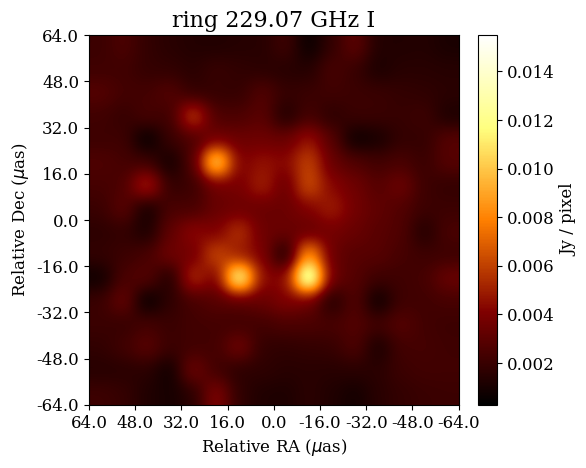

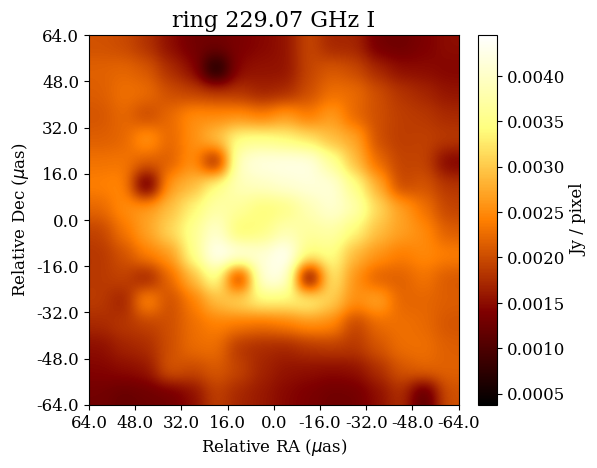

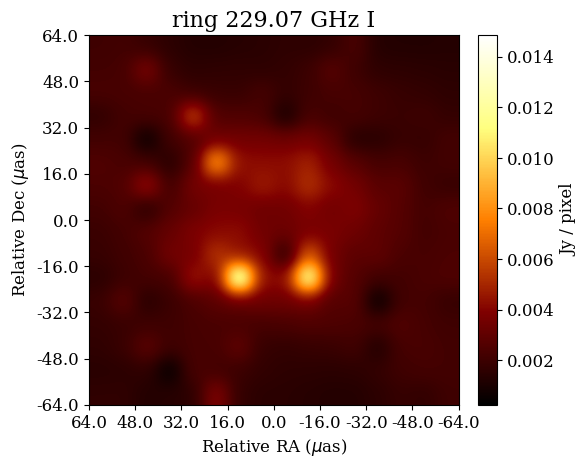

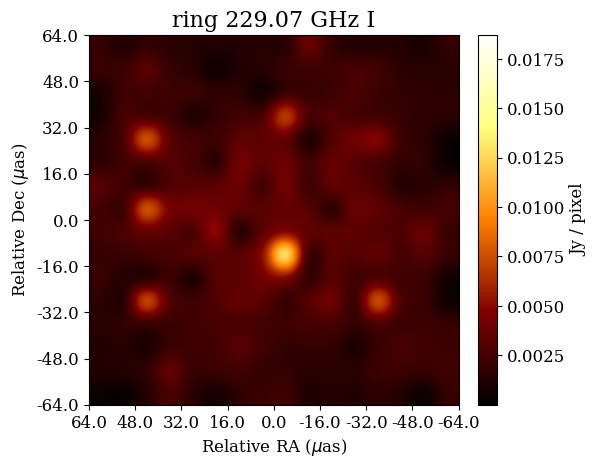

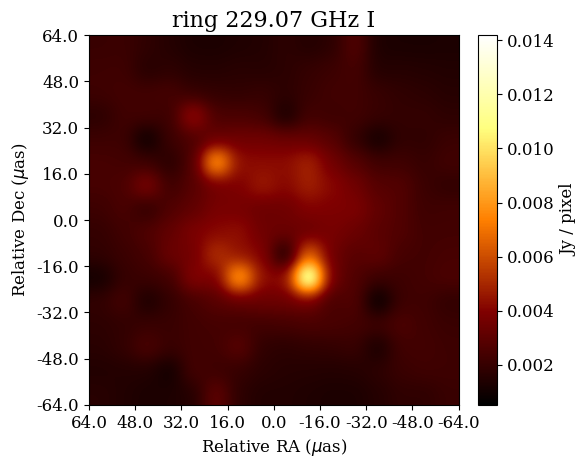

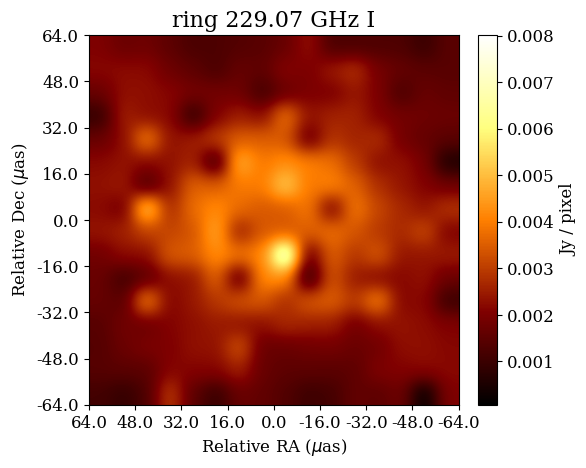

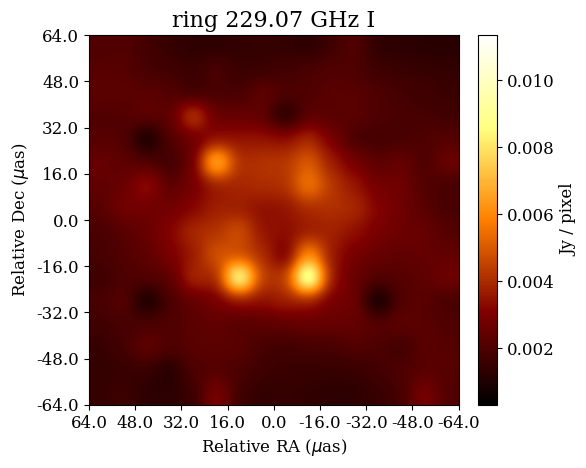

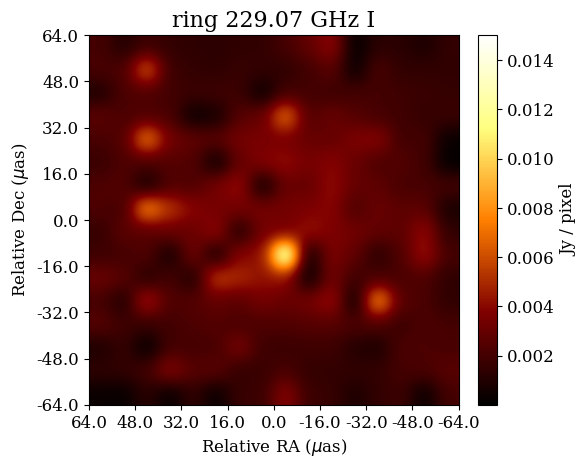

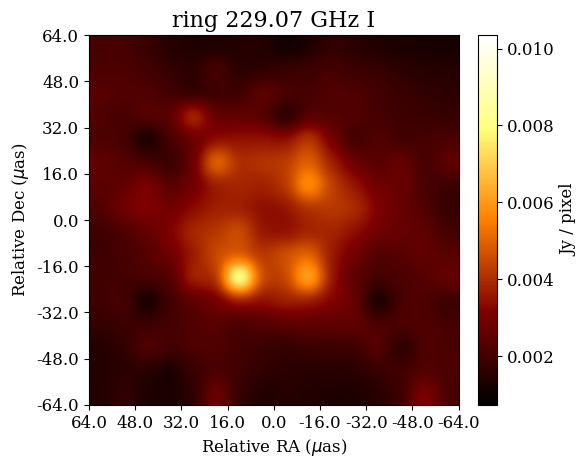

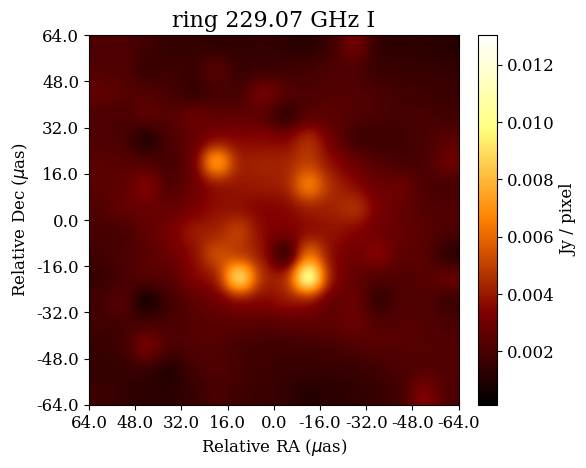

In [10]:
# Et voilà! evolve and getting the sol

pop = algo.evolve(pop)

fits, vectors = pop.get_f(), pop.get_x()

# And print some random solutions

save = False

#mrpiay randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(100)]
randsel = [np.random.random_integers(1, len(vectors)-1) for i in range(10)]
im=eh.image.load_fits('./mrbeam/mr_beam/mrpiay/ring_16.fits')
for i in randsel:
   im.imvec = vectors[i]*rescaling
   im.display() #for saving im.display(export_pdf='path/name.png/pdf')
if save:
   import os
   os.system('rm %s_vectors*' % outfile)
   np.savetxt(outfile+'_fits.npy',fits)
   np.savetxt(outfile+'_vectors.npy',vectors)
   np.savetxt(outfile+'_weights.npy',weights)